# ForestAtRisk Tropics

This notebook provides a minimal and reproducible example for the following scientific article:

**Vieilledent G., C. Vancutsem, C. Bourgoin, P. Ploton, P. Verley, and F. Achard.** Spatial scenario of tropical deforestation and carbon emissions for the 21<sup>st</sup> century. _bioRxiv_.
\[doi:[10.1101/2022.03.22.485306](https://doi.org/10.1101/2022.03.22.485306)\]. [Manuscript](https://www.biorxiv.org/content/10.1101/2022.03.22.485306v2.full.pdf). [Supplementary Information](https://www.biorxiv.org/content/biorxiv/early/2022/07/23/2022.03.22.485306/DC1/embed/media-1.pdf).

We use the [Guadeloupe](https://en.wikipedia.org/wiki/Guadeloupe) archipelago as a case study.

In [1]:
# Imports
import os
import re
from shutil import copy2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import forestatrisk as far

# forestatrisk: modelling and forecasting deforestation in the tropics.
# https://ecology.ghislainv.fr/forestatrisk/


We create a directory to hold the outputs with the help of the function `.make_dir()`.

In [2]:
# Make output directory
far.make_dir("output")

## 1. Data

### 1.1 Import and unzip the data

In [3]:
import urllib.request
from zipfile import ZipFile

# Source of the data
url = "https://github.com/ghislainv/forestatrisk/raw/master/docsrc/notebooks/data_GLP.zip"

if os.path.exists("data_GPL.zip") is False:
    urllib.request.urlretrieve(url, "data_GPL.zip")
    with ZipFile("data_GPL.zip", "r") as z:
        z.extractall("data")

### 1.2 Files

The `data` folder includes:

- Forest cover change data for the period 2010-2020 as a GeoTiff raster file (`data/fcc23.tif`).
- Spatial explanatory variables as GeoTiff raster files (`.tif` extension, eg. `data/dist_edge.tif` for distance to forest edge).
- Additional folders: `forest`, `forecast`, and `emissions`, with forest cover change for different periods of time, explanatory variables at different dates used for projections in the future, and forest carbon data for computing carbon emissions. 

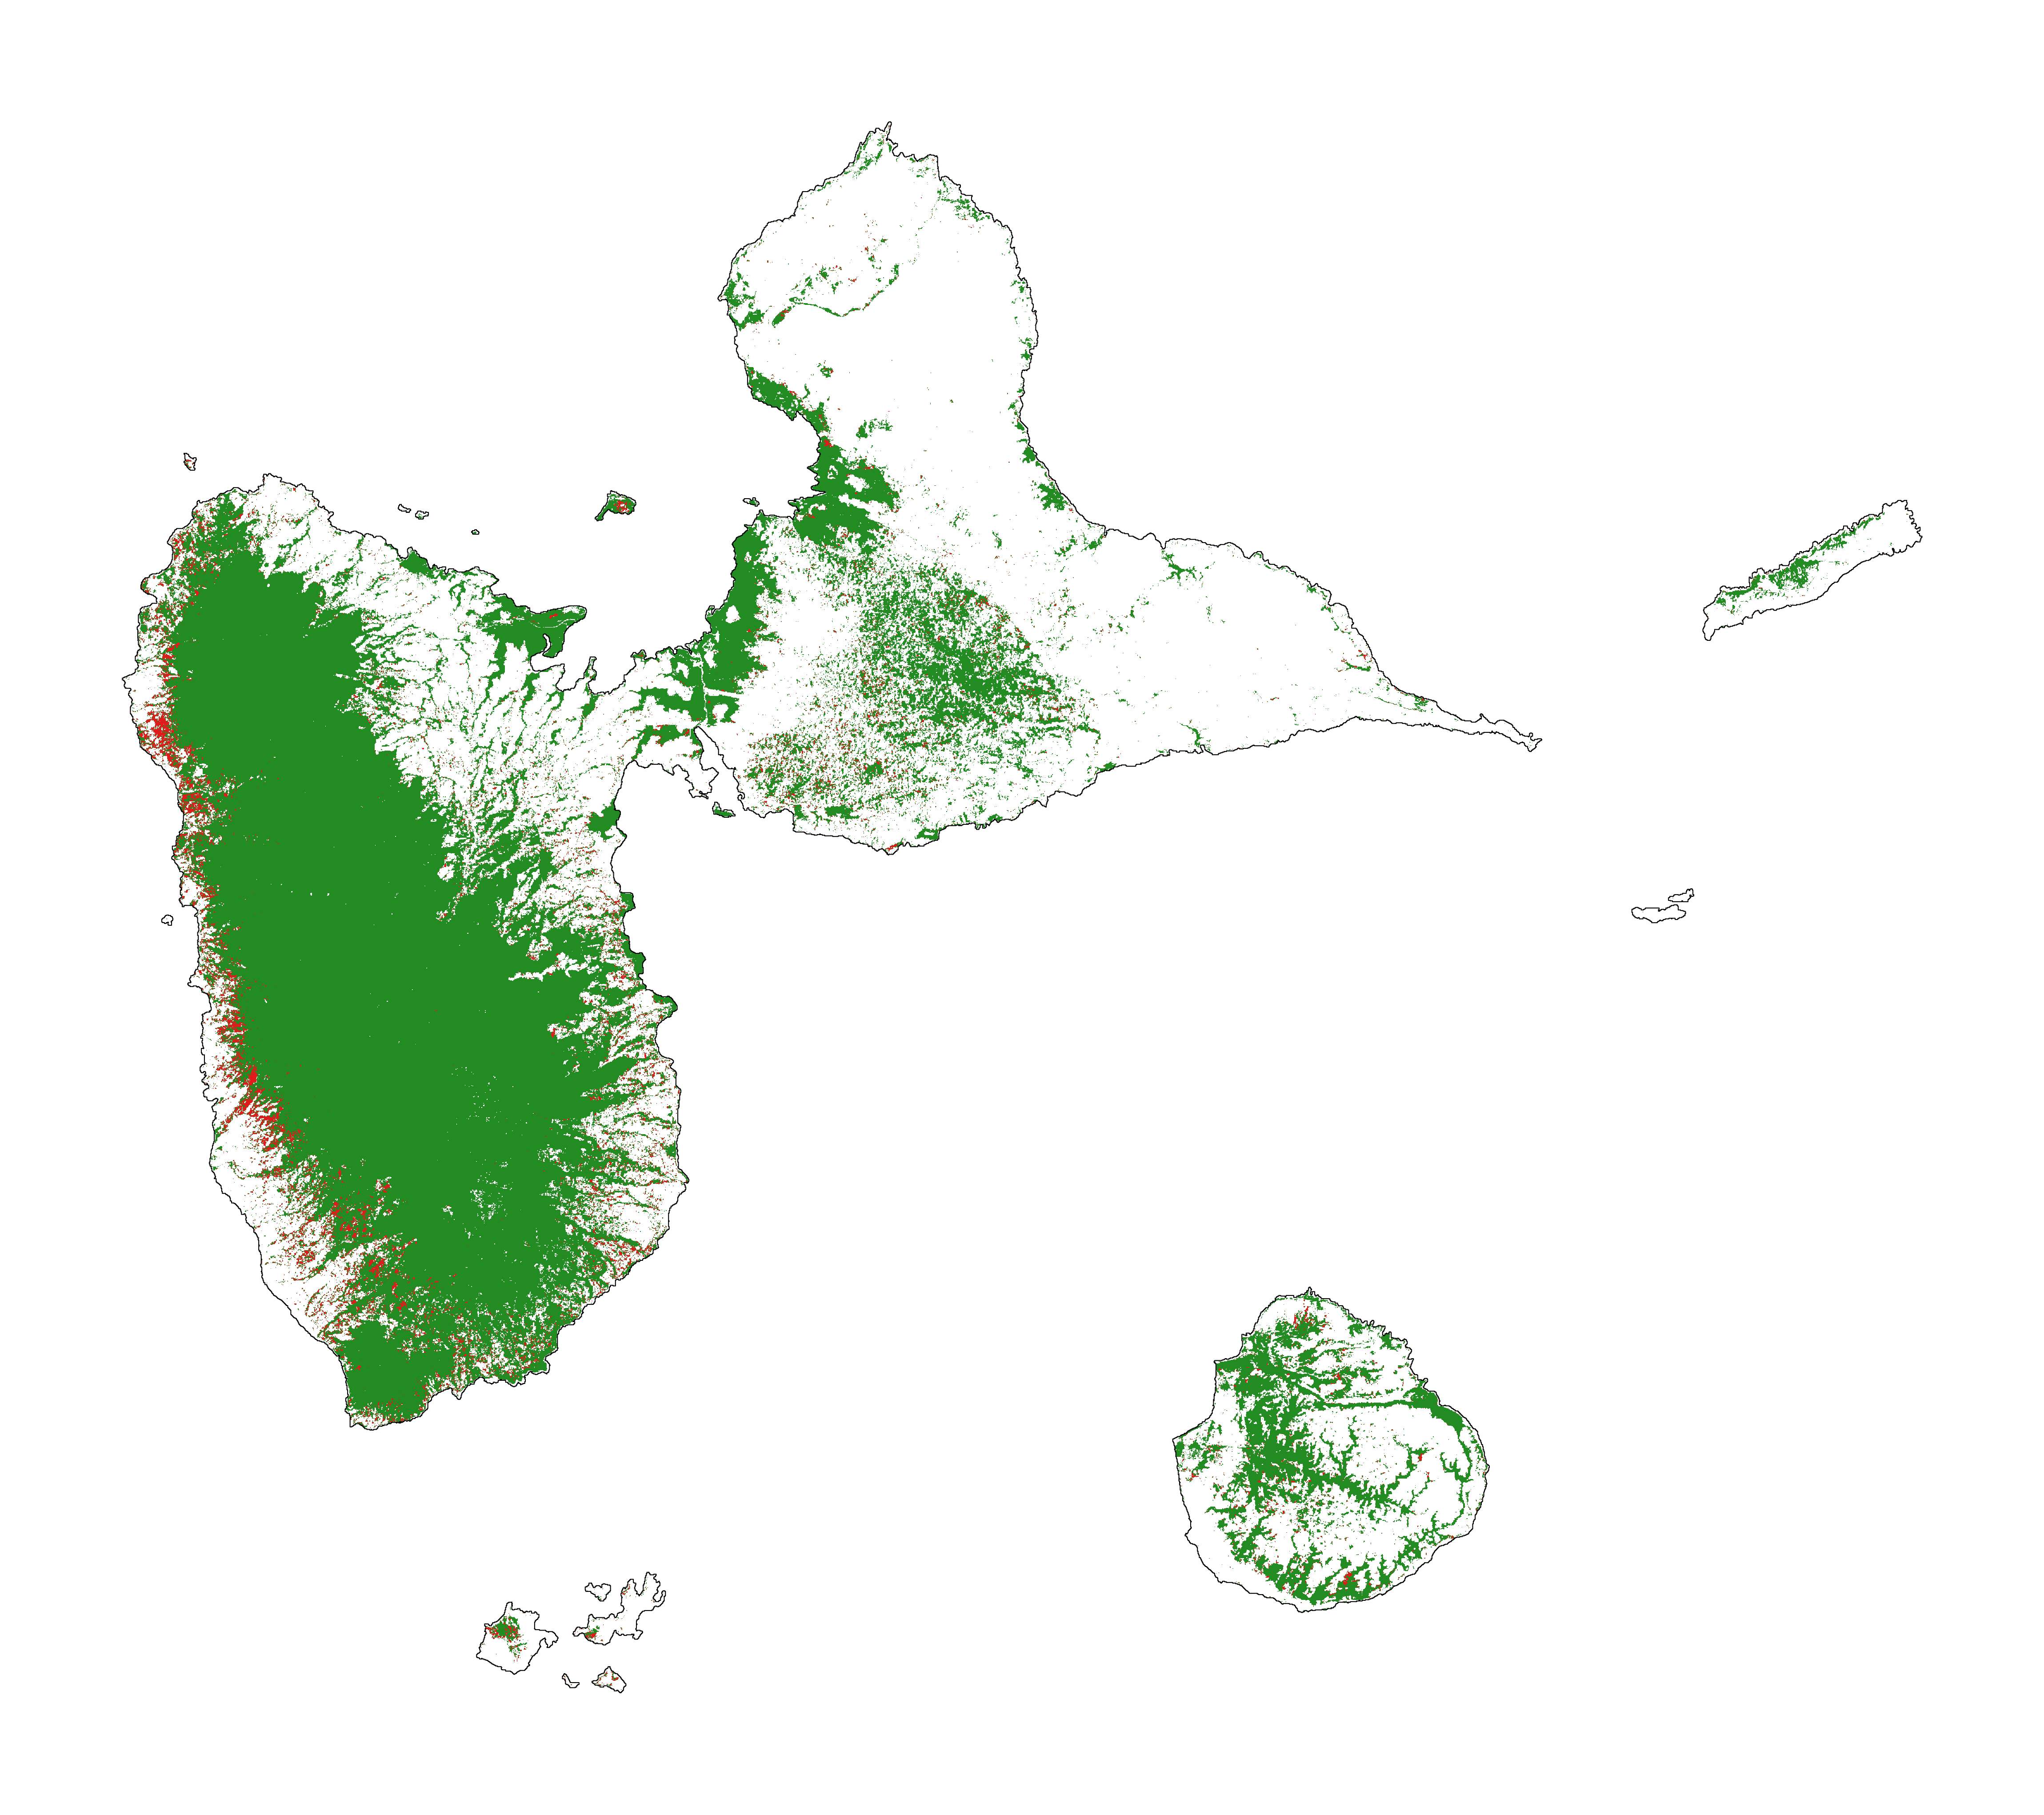

In [4]:
# Plot forest
fig_fcc23 = far.plot.fcc(
    input_fcc_raster="data/fcc23.tif",
    maxpixels=1e8,
    output_file="output/fcc23.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3, dpi=500)

### 1.3 Sampling the observations



In [5]:
# Sample points
dataset = far.sample(nsamp=10000, adapt=True, seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc23.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

Sample 2x 10000 pixels (deforested vs. forest)
Divide region in 168 blocks
Compute number of deforested and forest pixels per block
100%
Draw blocks at random
Draw pixels at random in blocks
100%
Compute center of pixel coordinates
Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify cell number from XY coordinates
Make virtual raster with variables as raster bands
Extract raster values for selected pixels
100%
Export results to file output/sample.txt


In [6]:
# Remove NA from data-set (otherwise scale() and
# model_binomial_iCAR doesn't work)
dataset = dataset.dropna(axis=0)
# Set number of trials to one for far.model_binomial_iCAR()
dataset["trial"] = 1
# Print the first five rows
print(dataset.head(5))

   altitude  dist_defor  dist_edge  dist_river  dist_road  dist_town  fcc23  \
0      30.0       642.0       30.0      8448.0     1485.0     6364.0    0.0   
1      37.0       765.0       30.0      8583.0     1697.0     6576.0    0.0   
2      78.0       216.0       30.0      7722.0      949.0     5743.0    0.0   
3      80.0       277.0       30.0      8168.0     1172.0     6047.0    0.0   
4      46.0        30.0       30.0      6179.0      541.0     6690.0    0.0   

    pa  slope          X          Y  cell  trial  
0  0.0    8.0 -6842295.0  1851975.0   4.0      1  
1  0.0    7.0 -6842235.0  1852095.0   4.0      1  
2  0.0    5.0 -6842535.0  1851195.0   4.0      1  
3  0.0    2.0 -6842445.0  1851615.0   4.0      1  
4  0.0    1.0 -6840465.0  1849755.0   4.0      1  


In [7]:
# Sample size
ndefor = sum(dataset.fcc23 == 0)
nfor = sum(dataset.fcc23 == 1)
with open("output/sample_size.csv", "w") as f:
    f.write("var, n\n")
    f.write("ndefor, " + str(ndefor) + "\n")
    f.write("nfor, " + str(nfor) + "\n")
print("ndefor = {}, nfor = {}".format(ndefor, nfor))

ndefor = 9923, nfor = 9979


### 1.4 Correlation plots

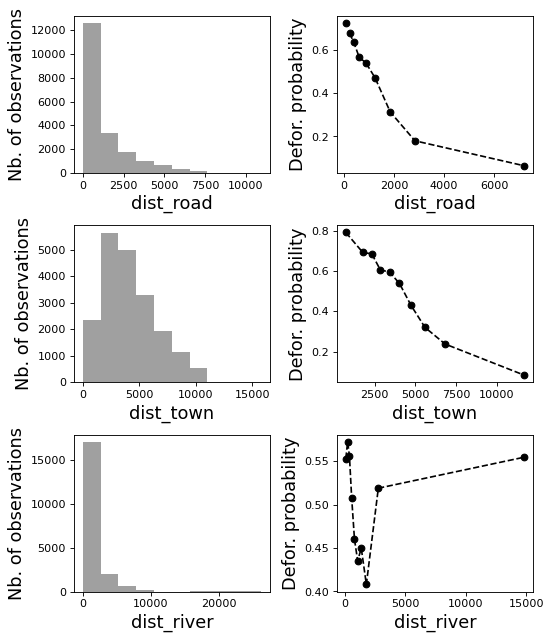

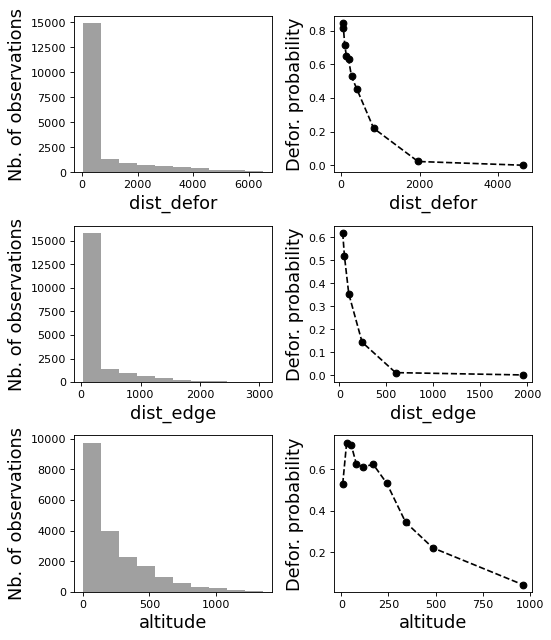

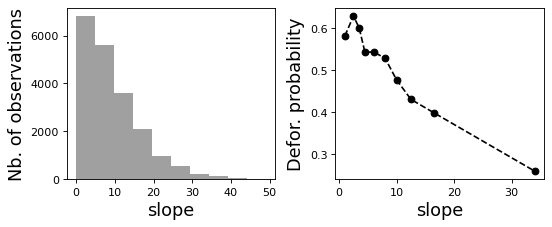

In [8]:
# Correlation formula
formula_corr = "fcc23 ~ dist_road + dist_town + dist_river + \
dist_defor + dist_edge + altitude + slope - 1"

# Output file
of = "output/correlation.pdf"
# Data
y, data = dmatrices(formula_corr, data=dataset,
                    return_type="dataframe")
# Plots
figs = far.plot.correlation(
    y=y, data=data,
    plots_per_page=3,
    figsize=(7, 8),
    dpi=80,
    output_file=of)

## 2. Model

### 2.1 Model preparation

In [9]:
# Neighborhood for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["C(pa)", "scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]
# Transform into numpy array
variables = np.array(variables)

# Starting values
beta_start = -99  # Simple GLM estimates
# Priors
priorVrho = -1  # -1="1/Gamma"

Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify adjacent cells and compute number of neighbors


### 2.2 Variable selection

In [10]:
# Run model while there is non-significant variables
var_remove = True
while(np.any(var_remove)):
    # Formula
    right_part = " + ".join(variables) + " + cell"
    left_part = "I(1-fcc23) + trial ~ "
    formula = left_part + right_part
    # Model
    mod_binomial_iCAR = far.model_binomial_iCAR(
        # Observations
        suitability_formula=formula, data=dataset,
        # Spatial structure
        n_neighbors=nneigh, neighbors=adj,
        # Priors
        priorVrho=priorVrho,
        # Chains
        burnin=1000, mcmc=1000, thin=1,
        # Starting values
        beta_start=beta_start)
    # Ecological and statistical significance
    effects = mod_binomial_iCAR.betas[1:]
    # MCMC = mod_binomial_iCAR.mcmc
    # CI_low = np.percentile(MCMC, 2.5, axis=0)[1:-2]
    # CI_high = np.percentile(MCMC, 97.5, axis=0)[1:-2]
    positive_effects = (effects >= 0)
    # zero_in_CI = ((CI_low * CI_high) <= 0)
    # Keeping only significant variables
    var_remove = positive_effects
    # var_remove = np.logical_or(positive_effects, zero_in_CI)
    var_keep = np.logical_not(var_remove)
    variables = variables[var_keep]

Using estimates from classic logistic regression as starting values for betas
Using estimates from classic logistic regression as starting values for betas


### 2.3 Final model

In [11]:
# Re-run the model with longer MCMC and estimated initial values
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Priors
    priorVrho=priorVrho,
    # Chains
    burnin=5000, mcmc=5000, thin=5,
    # Starting values
    beta_start=mod_binomial_iCAR.betas)

### 2.4 Model summary

In [12]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_hSDM.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

Binomial logistic regression with iCAR process
  Model: I(1 - fcc23) + trial ~ 1 + scale(altitude) + scale(dist_defor) + scale(dist_edge) + scale(dist_road) + scale(dist_town) + scale(dist_river) + cell
  Posteriors:
                        Mean        Std     CI_low    CI_high
        Intercept      -3.98      0.303       -4.5      -3.37
  scale(altitude)     -0.522      0.105     -0.731     -0.321
scale(dist_defor)      -2.12      0.288      -2.71      -1.56
 scale(dist_edge)      -7.08      0.525      -8.01      -6.08
 scale(dist_road)    -0.0389     0.0657     -0.162     0.0885
 scale(dist_town)     -0.092      0.041     -0.176    -0.0134
scale(dist_river)    -0.0129     0.0319    -0.0735     0.0502
             Vrho        3.1      0.815       1.86       4.92
         Deviance   1.52e+04       48.1   1.52e+04   1.54e+04



MCMC traces

Traces and posteriors will be plotted in output/mcmc.pdf


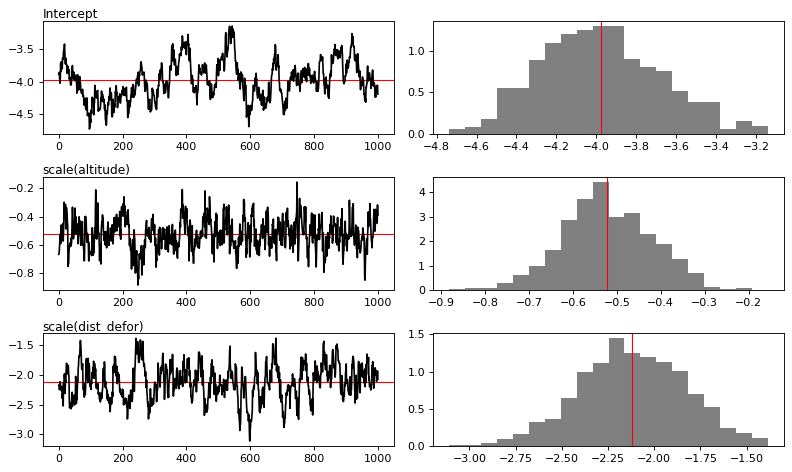

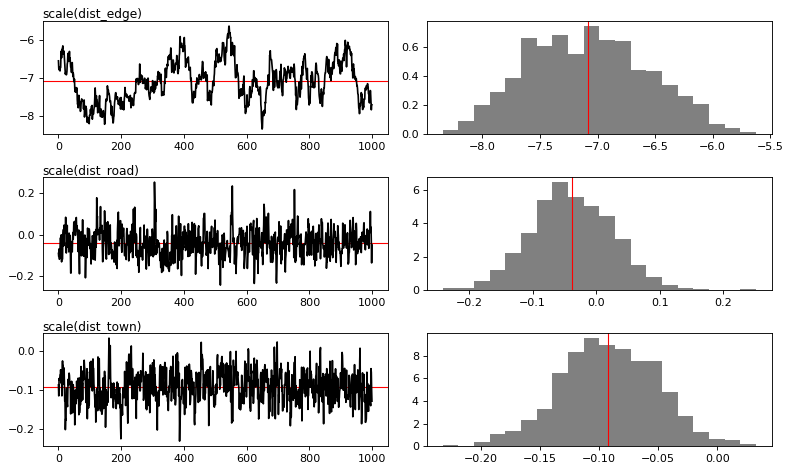

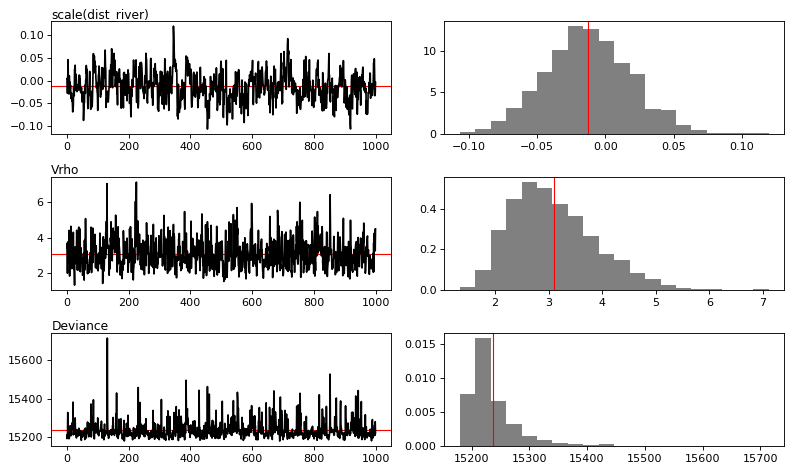

In [13]:
# Plot
figs = mod_binomial_iCAR.plot(
    output_file="output/mcmc.pdf",plots_per_page=3,
    figsize=(10, 6),
    dpi=80)

In [14]:
# Save model's main specifications with pickle
mod_icar_pickle = {
    "formula": mod_binomial_iCAR.suitability_formula,
    "rho": mod_binomial_iCAR.rho,
    "betas": mod_binomial_iCAR.betas,
    "Vrho": mod_binomial_iCAR.Vrho,
    "deviance": mod_binomial_iCAR.deviance}
with open("output/mod_icar.pickle", "wb") as pickle_file:
    pickle.dump(mod_icar_pickle, pickle_file)

## 3. Model comparison and validation

### 3.1 Cross-validation

In [15]:
# Cross-validation for icar, glm and RF
CV_df_icar = far.cross_validation(
    dataset, formula, mod_type="icar", ratio=30, nrep=5,
    icar_args={"n_neighbors": nneigh, "neighbors": adj,
               "burnin": 1000, "mcmc": 1000, "thin": 1,
               "beta_start": mod_binomial_iCAR.betas})

CV_df_glm = far.cross_validation(dataset, formula, mod_type="glm", ratio=30, nrep=5)

CV_df_rf = far.cross_validation(dataset, formula, mod_type="rf", ratio=30, nrep=5,
                                rf_args={"n_estimators": 500, "n_jobs": 3})

# Save result to disk
CV_df_icar.to_csv("output/CV_icar.csv", header=True, index=False)
CV_df_glm.to_csv("output/CV_glm.csv", header=True, index=False)
CV_df_rf.to_csv("output/CV_rf.csv", header=True, index=False)

Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5
Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5
Repetition #: 1
Repetition #: 2
Repetition #: 3
Repetition #: 4
Repetition #: 5


In [16]:
print(CV_df_icar)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.9070  0.9065  0.9040  0.9032  0.9037  0.9049
1    OA  0.8245  0.8245  0.8218  0.8191  0.8164  0.8213
2    EA  0.5001  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.7044  0.6962  0.6946  0.6952  0.6875  0.6956
4   Sen  0.8265  0.8209  0.8198  0.8202  0.8148  0.8204
5   Spe  0.8224  0.8279  0.8238  0.8181  0.8181  0.8220
6   TSS  0.6489  0.6488  0.6436  0.6382  0.6329  0.6425
7     K  0.6489  0.6488  0.6436  0.6382  0.6329  0.6425


In [17]:
print(CV_df_glm)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.8843  0.8834  0.8810  0.8842  0.8877  0.8841
1    OA  0.8037  0.7980  0.7937  0.8017  0.8041  0.8002
2    EA  0.5001  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.6751  0.6583  0.6547  0.6707  0.6699  0.6657
4   Sen  0.8060  0.7939  0.7913  0.8029  0.8023  0.7993
5   Spe  0.8014  0.8020  0.7960  0.8005  0.8058  0.8011
6   TSS  0.6074  0.5959  0.5873  0.6034  0.6081  0.6004
7     K  0.6074  0.5959  0.5873  0.6034  0.6081  0.6004


In [18]:
print(CV_df_rf)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.9133  0.9063  0.9116  0.9100  0.9107  0.9104
1    OA  0.8339  0.8235  0.8292  0.8280  0.8282  0.8285
2    EA  0.5001  0.5001  0.5000  0.5000  0.5000  0.5001
3   FOM  0.7175  0.6956  0.7099  0.7089  0.7056  0.7075
4   Sen  0.8369  0.8216  0.8303  0.8298  0.8279  0.8293
5   Spe  0.8307  0.8253  0.8280  0.8262  0.8284  0.8277
6   TSS  0.6677  0.6469  0.6583  0.6560  0.6563  0.6570
7     K  0.6677  0.6469  0.6583  0.6560  0.6563  0.6570


### 3.2 Deviance

In [19]:
# Null model
formula_null = "I(1-fcc23) ~ 1"
y, x = dmatrices(formula_null, data=dataset, NA_action="drop")
Y = y[:, 0]
X_null = x[:, :]
mod_null = LogisticRegression(solver="lbfgs")
mod_null = mod_null.fit(X_null, Y)
pred_null = mod_null.predict_proba(X_null)

# Simple glm with no spatial random effects
formula_glm = formula
y, x = dmatrices(formula_glm, data=dataset, NA_action="drop")
Y = y[:, 0]
X_glm = x[:, :-1]  # We remove the last column (cells)
mod_glm = LogisticRegression(solver="lbfgs")
mod_glm = mod_glm.fit(X_glm, Y)
pred_glm = mod_glm.predict_proba(X_glm)

# Random forest model
formula_rf = formula
y, x = dmatrices(formula_rf, data=dataset, NA_action="drop")
Y = y[:, 0]
X_rf = x[:, :-1]  # We remove the last column (cells)
mod_rf = RandomForestClassifier(n_estimators=500, n_jobs=3)
mod_rf = mod_rf.fit(X_rf, Y)
pred_rf = mod_rf.predict_proba(X_rf)

# Deviances
deviance_null = 2*log_loss(Y, pred_null, normalize=False)
deviance_glm = 2*log_loss(Y, pred_glm, normalize=False)
deviance_rf = 2*log_loss(Y, pred_rf, normalize=False)
deviance_icar = mod_binomial_iCAR.deviance
deviance_full = 0
dev = [deviance_null, deviance_glm, deviance_rf, deviance_icar, deviance_full]

# Result table
mod_dev = pd.DataFrame({"model": ["null", "glm", "rf", "icar", "full"],
                        "deviance": dev})
perc = 100*(1-mod_dev.deviance/deviance_null)
mod_dev["perc"] = perc
mod_dev = mod_dev.round(0)
mod_dev.to_csv("output/model_deviance.csv", header=True, index=False)

In [20]:
print(mod_dev)

  model  deviance   perc
0  null   27590.0    0.0
1   glm   16542.0   40.0
2    rf    3646.0   87.0
3  icar   15237.0   45.0
4  full       0.0  100.0


In [21]:
# Save models' predictions
obs_pred = dataset
obs_pred["null"] = pred_null[:, 1]
obs_pred["glm"] = pred_glm[:, 1]
obs_pred["rf"] = pred_rf[:, 1]
obs_pred["icar"] = pred_icar
obs_pred.to_csv("output/obs_pred.csv", header=True, index=False)

## 4. Predict

### 4.1 Interpolate spatial random effects

In [22]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

Write spatial random effect data to disk
Compute statistics
Build overview
Resampling spatial random effects to file output/rho.tif


### 4.2 Predict deforestation probability

In [23]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

Make virtual raster with variables as raster bands
Divide region in 296 blocks
Create a raster file on disk for projections
Predict deforestation probability by block
100%
Compute statistics


## 5. Project future forest cover change

In [24]:
# Forest cover
fc = list()
dates = ["t1", "2005", "t2", "2015", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[2] - fc[4]) / T

# Dates and time intervals
dates_fut = ["2030", "2035", "2040", "2050", "2055", "2060", "2070", "2080", "2085", "2090", "2100"]
ndates_fut = len(dates_fut)
ti = [10, 15, 20, 30, 35, 40, 50, 60, 65, 70, 80]


Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha


In [25]:
# Loop on dates
for i in range(ndates_fut):
    # Amount of deforestation (ha)
    defor = np.rint(annual_defor * ti[i])
    # Compute future forest cover
    stats = far.deforest(
        input_raster="output/prob.tif",
        hectares=defor,
        output_file="output/fcc_" + dates_fut[i] + ".tif",
        blk_rows=128)
    # Save some stats if date = 2050
    if dates_fut[i] == "2050":
        # Save stats to disk with pickle
        pickle.dump(stats, open("output/stats.pickle", "wb"))
        # Plot histograms of probabilities
        fig_freq = far.plot.freq_prob(
            stats, output_file="output/freq_prob.png")
        plt.close(fig_freq)

Divide region in 24 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 24 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 24 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statistics
Divide region in 24 blocks
Compute the total number of forest pixels
100%
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Write raster of future forest-cover change
100%
Compute statist

## 6. Carbon emissions

In [26]:
# Create dataframe
dpast = ["2020"]
dpast.extend(dates_fut)
C_df = pd.DataFrame({"date": dpast, "C": np.repeat(-99, ndates_fut + 1)},
                    columns=["date","C"])
# Loop on date
for i in range(ndates_fut):
    carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                           input_forest="output/fcc_" + dates_fut[i] + ".tif")
    C_df.loc[C_df["date"]==dates_fut[i], ["C"]] = carbon
# Past emissions 
carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                       input_forest="data/fcc23.tif")
C_df.loc[C_df["date"]==dpast[0], ["C"]] = carbon
# Save dataframe
C_df.to_csv("output/C_emissions.csv", header=True, index=False)

Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute

In [27]:
print(C_df)

    date       C
0   2020   85954
1   2030   98242
2   2035  151104
3   2040  201820
4   2050  289924
5   2055  334290
6   2060  381925
7   2070  481285
8   2080  587603
9   2085  644809
10  2090  705718
11  2100  843905


## 7. Figures

### 7.1 Historical forest cover change

Forest cover change for the period 2000-2010-2020

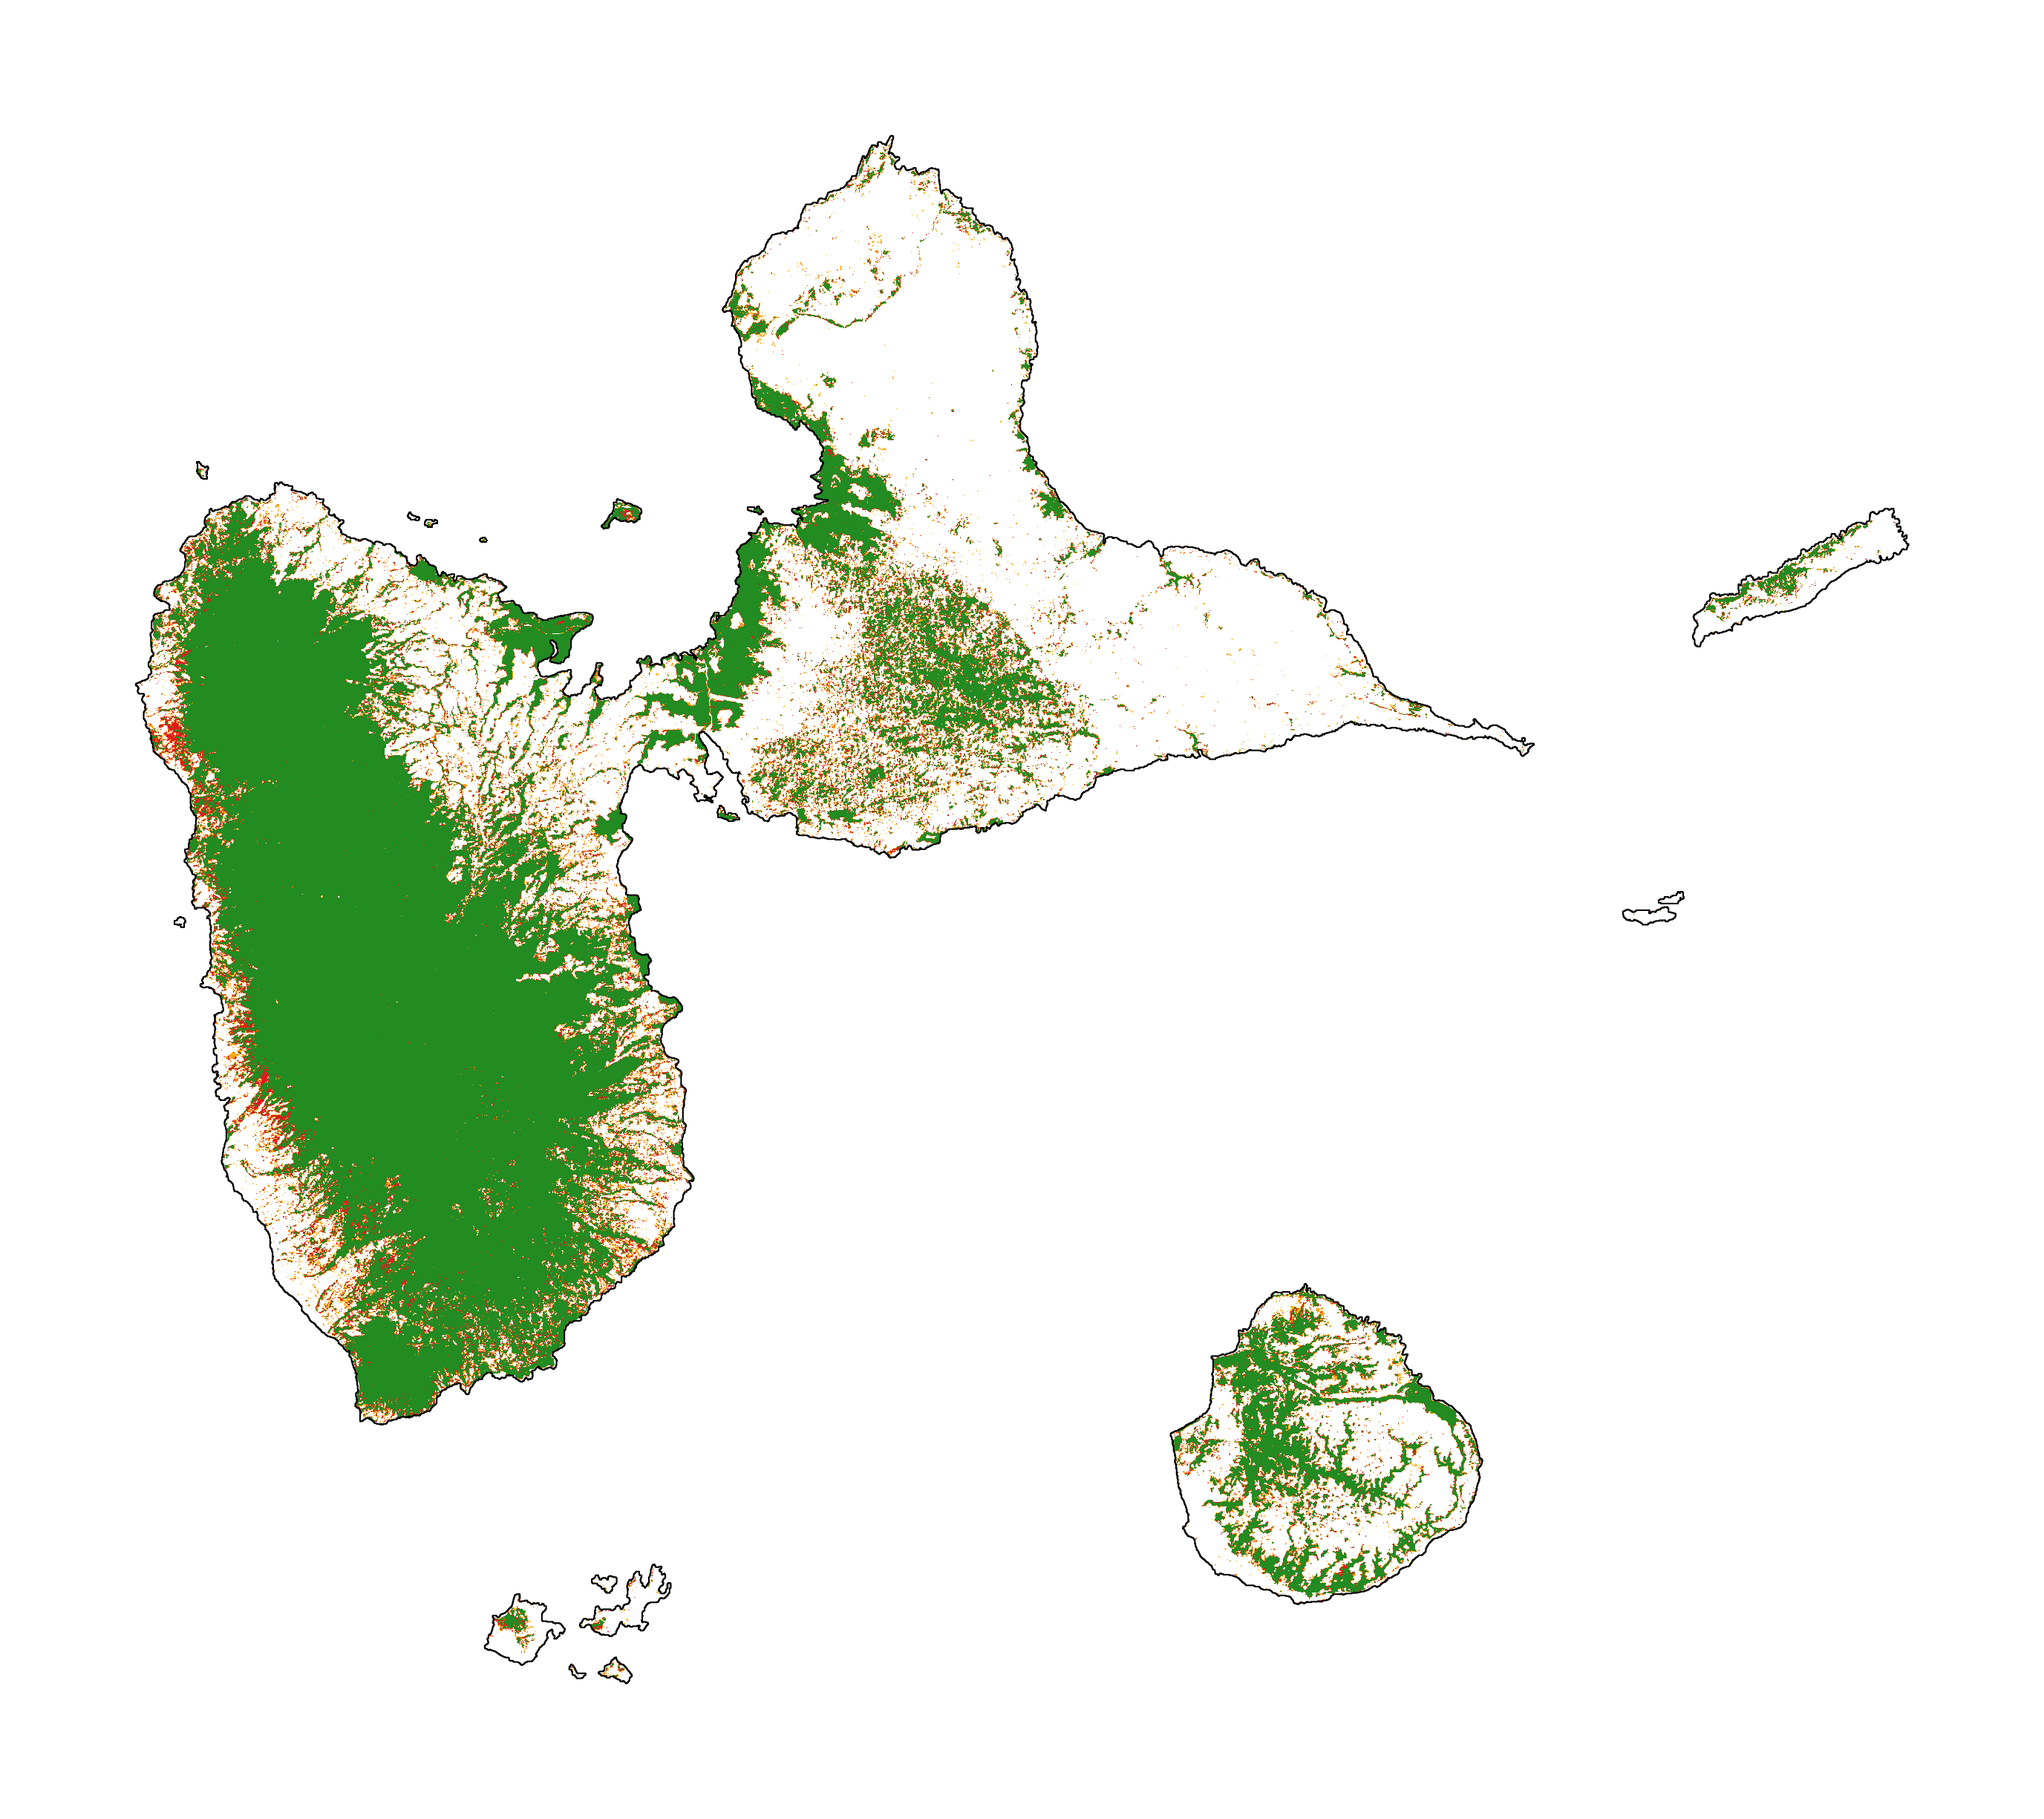

In [28]:
# Plot forest
fig_fcc123 = far.plot.fcc123(
    input_fcc_raster="data/forest/fcc123.tif",
    maxpixels=1e8,
    output_file="output/fcc123.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3,
    figsize=(6, 5), dpi=500)

### 7.2 Spatial random effects

Build overview


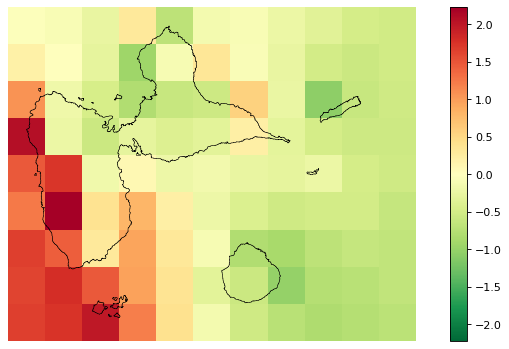

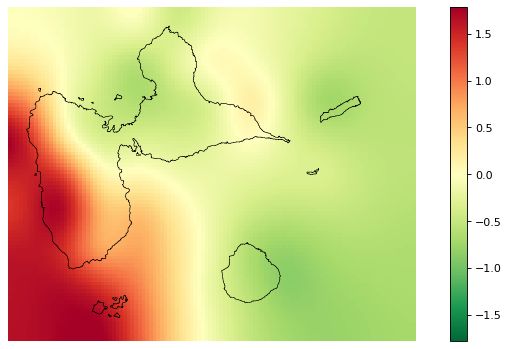

In [29]:
# Original spatial random effects
fig_rho_orig = far.plot.rho("output/rho_orig.tif",
                            borders="data/ctry_PROJ.shp",
                            linewidth=0.5,
                            output_file="output/rho_orig.png",
                            figsize=(9,5), dpi=80)

# Interpolated spatial random effects
fig_rho = far.plot.rho("output/rho.tif",
                       borders="data/ctry_PROJ.shp",
                       linewidth=0.5,
                       output_file="output/rho.png",
                       figsize=(9,5), dpi=80)

### 7.3 Spatial probability of deforestation

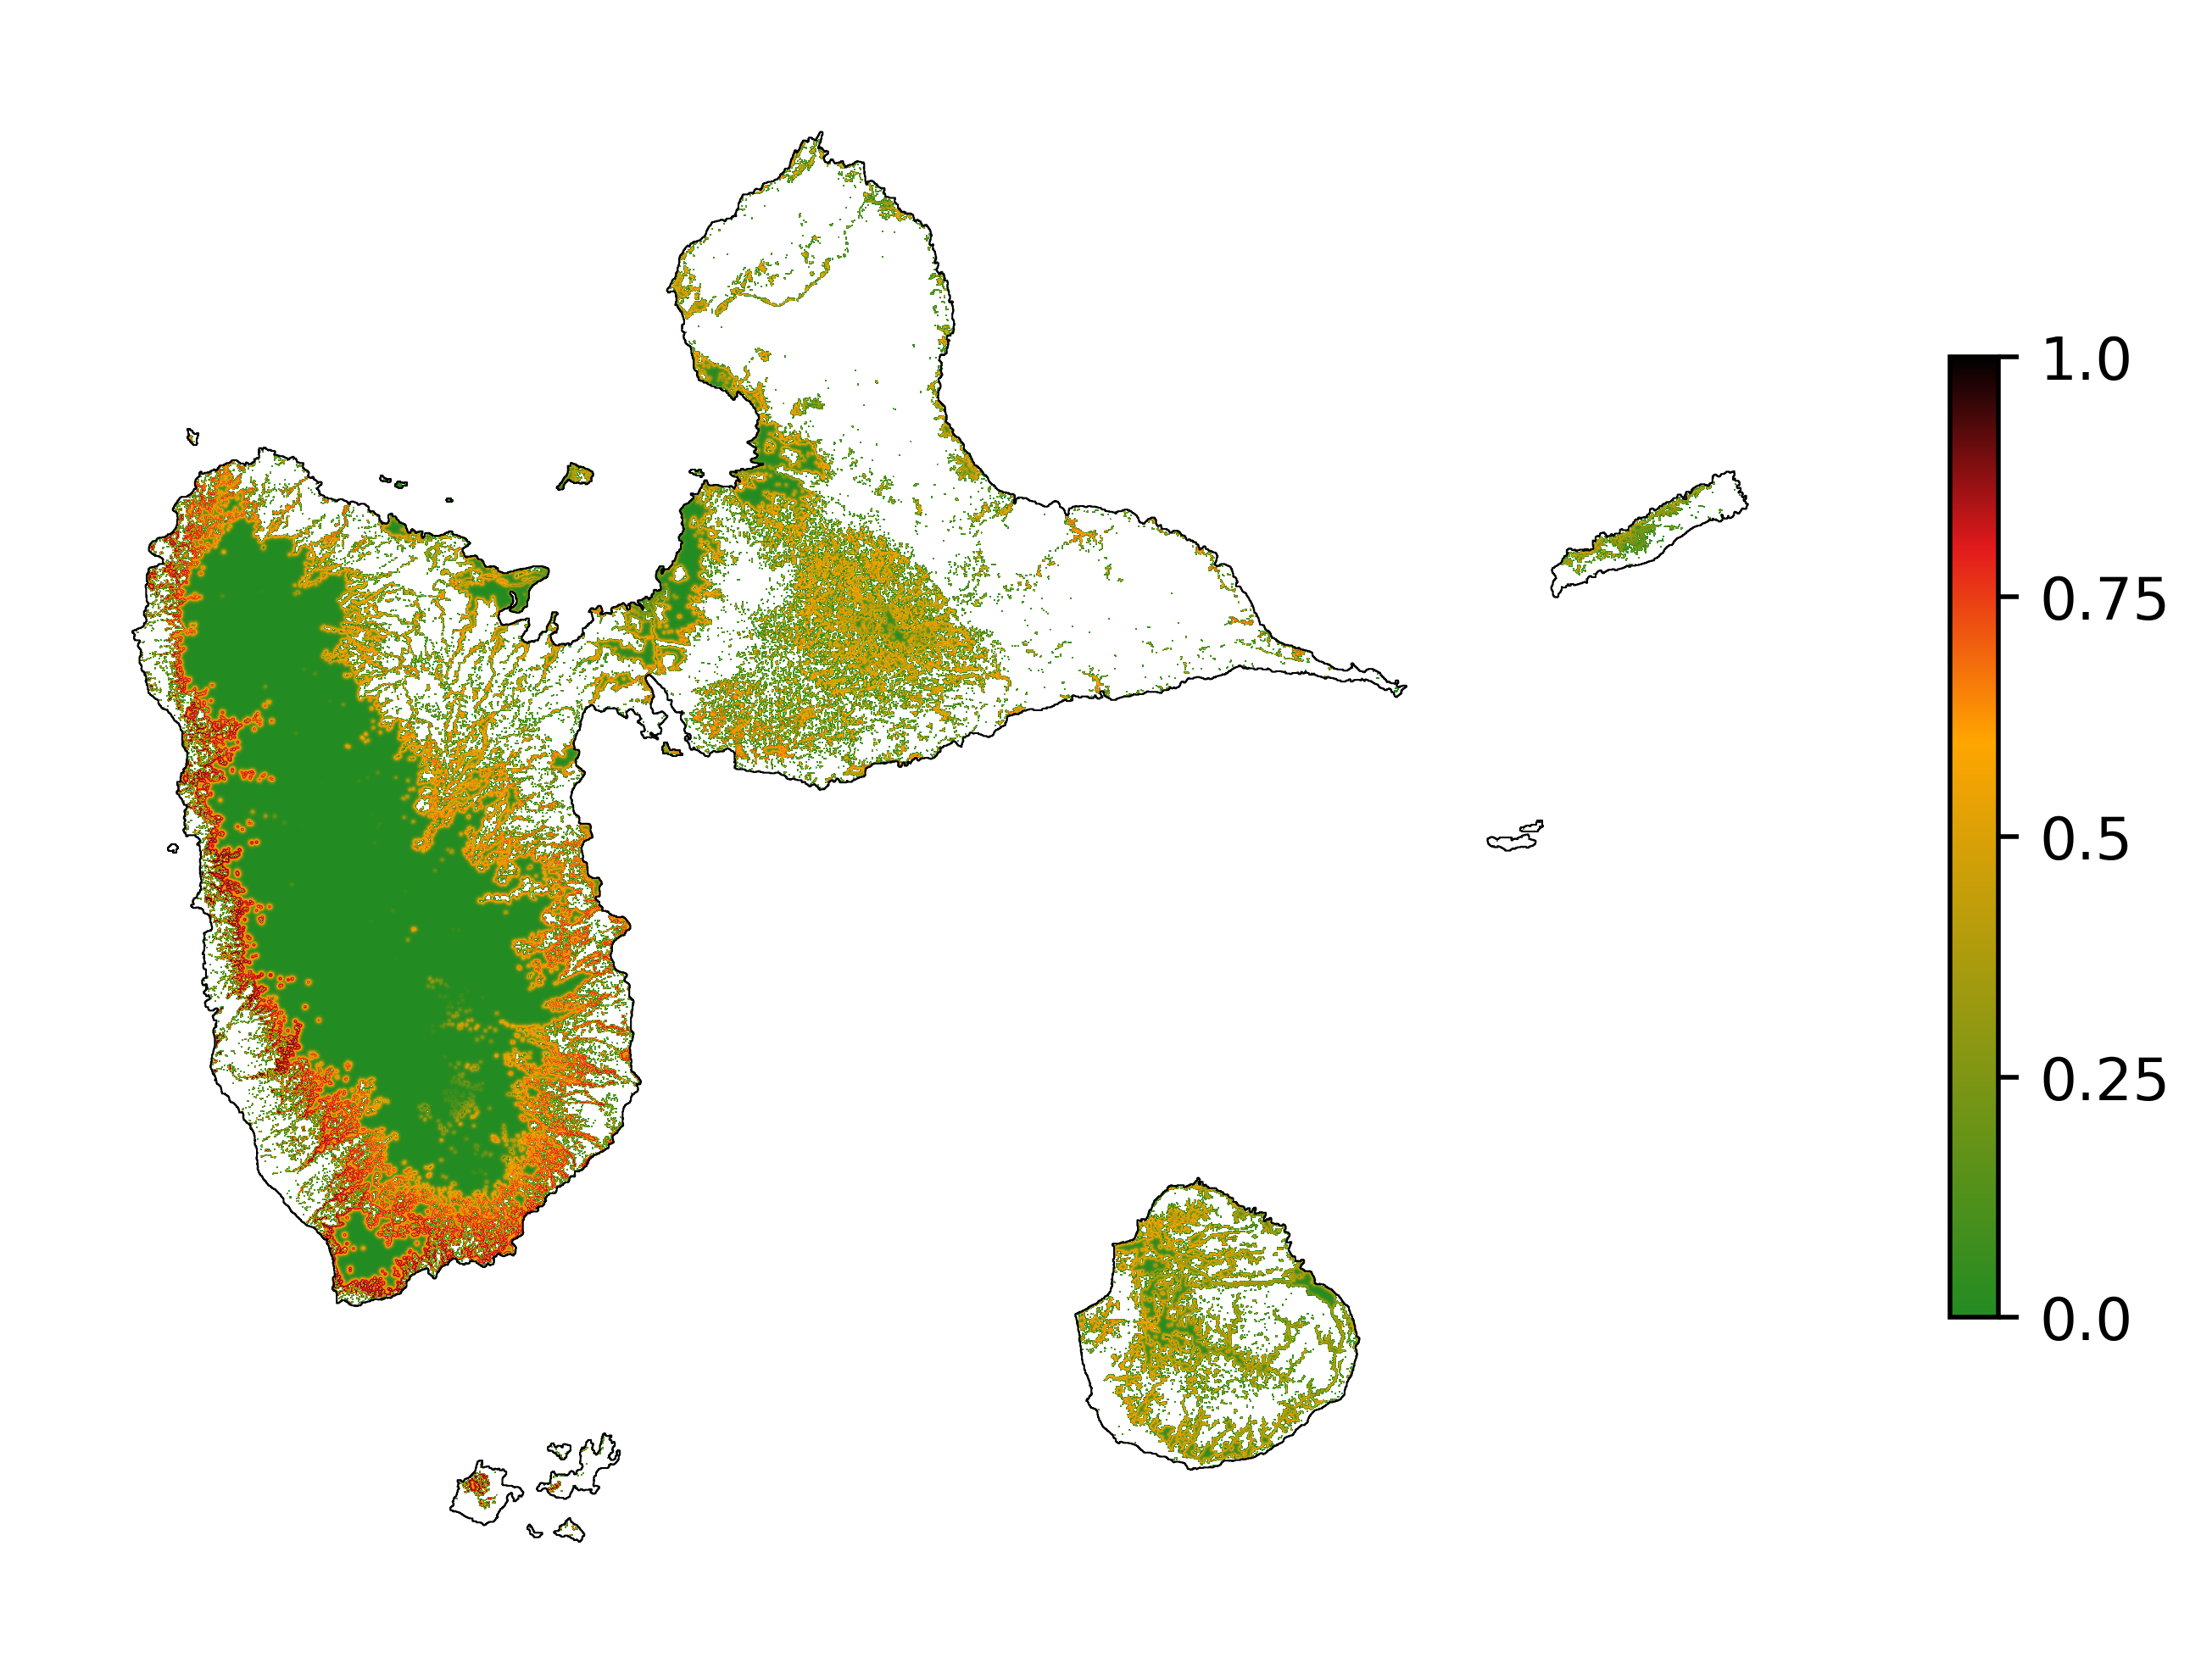

In [30]:
# Spatial probability of deforestation
fig_prob = far.plot.prob("output/prob.tif",
                         maxpixels=1e8,
                         borders="data/ctry_PROJ.shp",
                         linewidth=0.3,
                         legend=True,
                         output_file="output/prob.png",
                         figsize=(6, 5), dpi=500)

### 7.4 Future forest cover

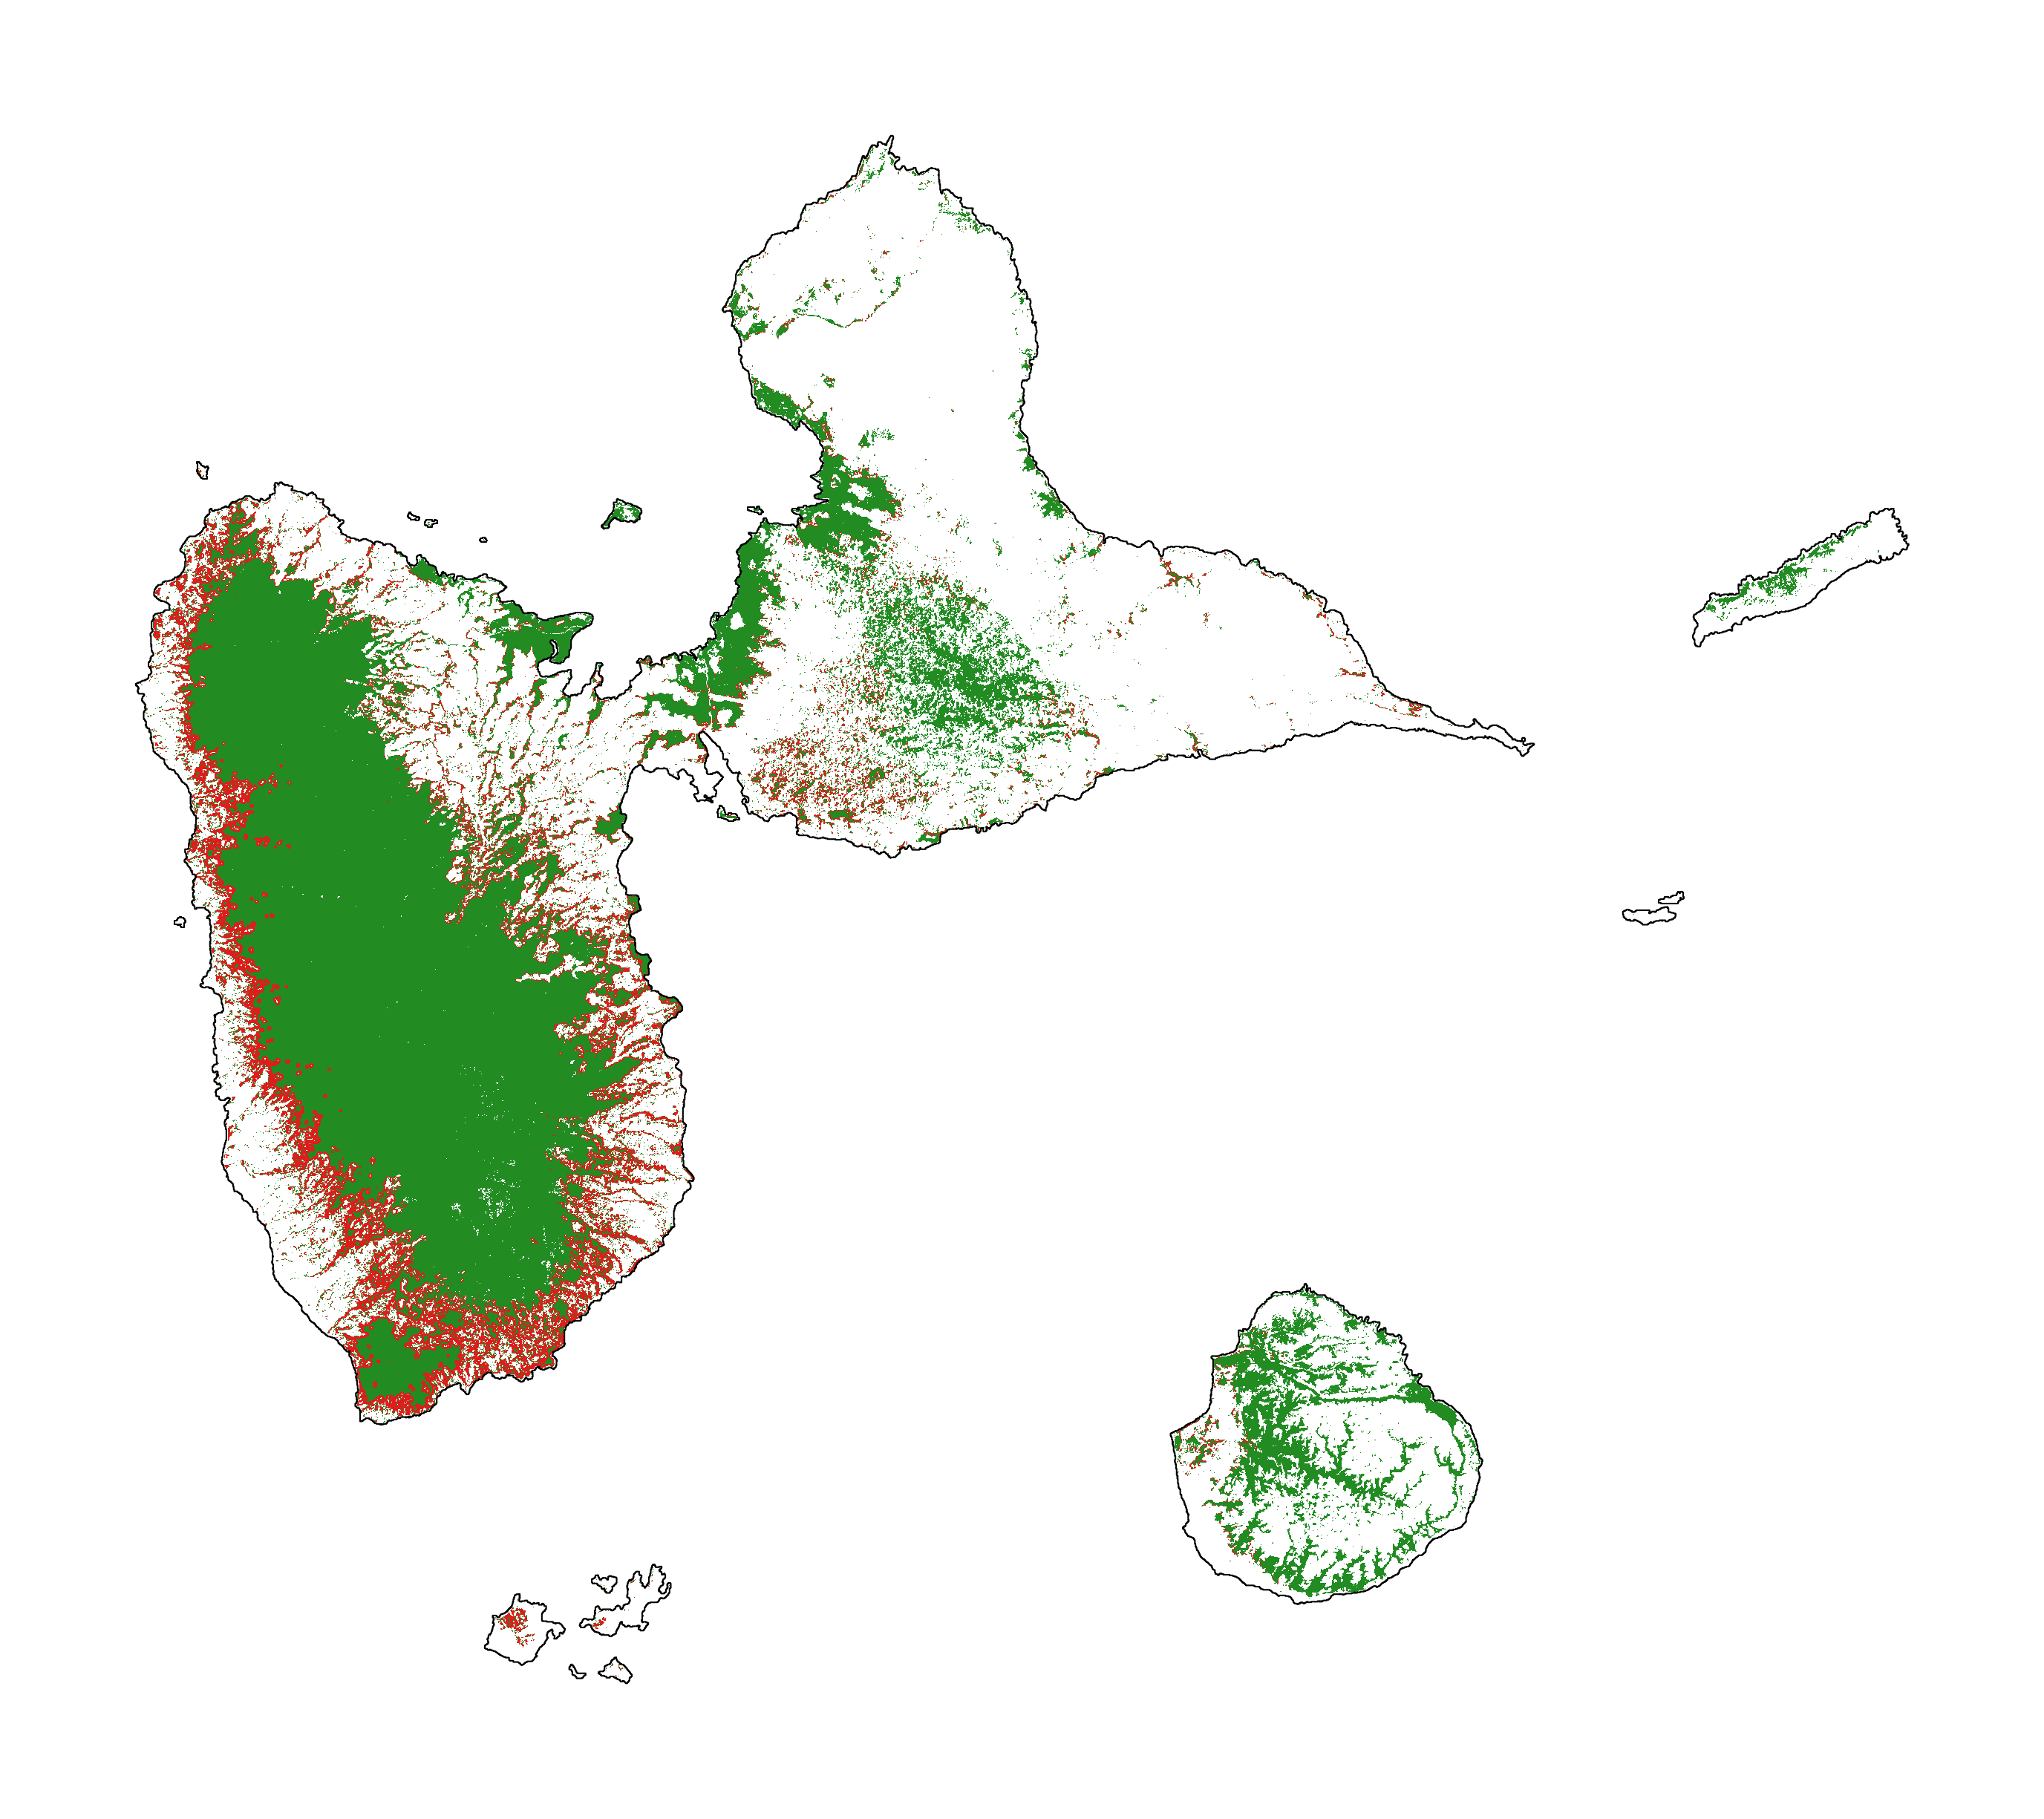

In [31]:
# Projected forest cover change (2020-2050)
fcc_2050 = far.plot.fcc("output/fcc_2050.tif",
                        maxpixels=1e8,
                        borders="data/ctry_PROJ.shp",
                        linewidth=0.3,
                        output_file="output/fcc_" + dates_fut[i] + ".png",
                        figsize=(6, 5), dpi=500)

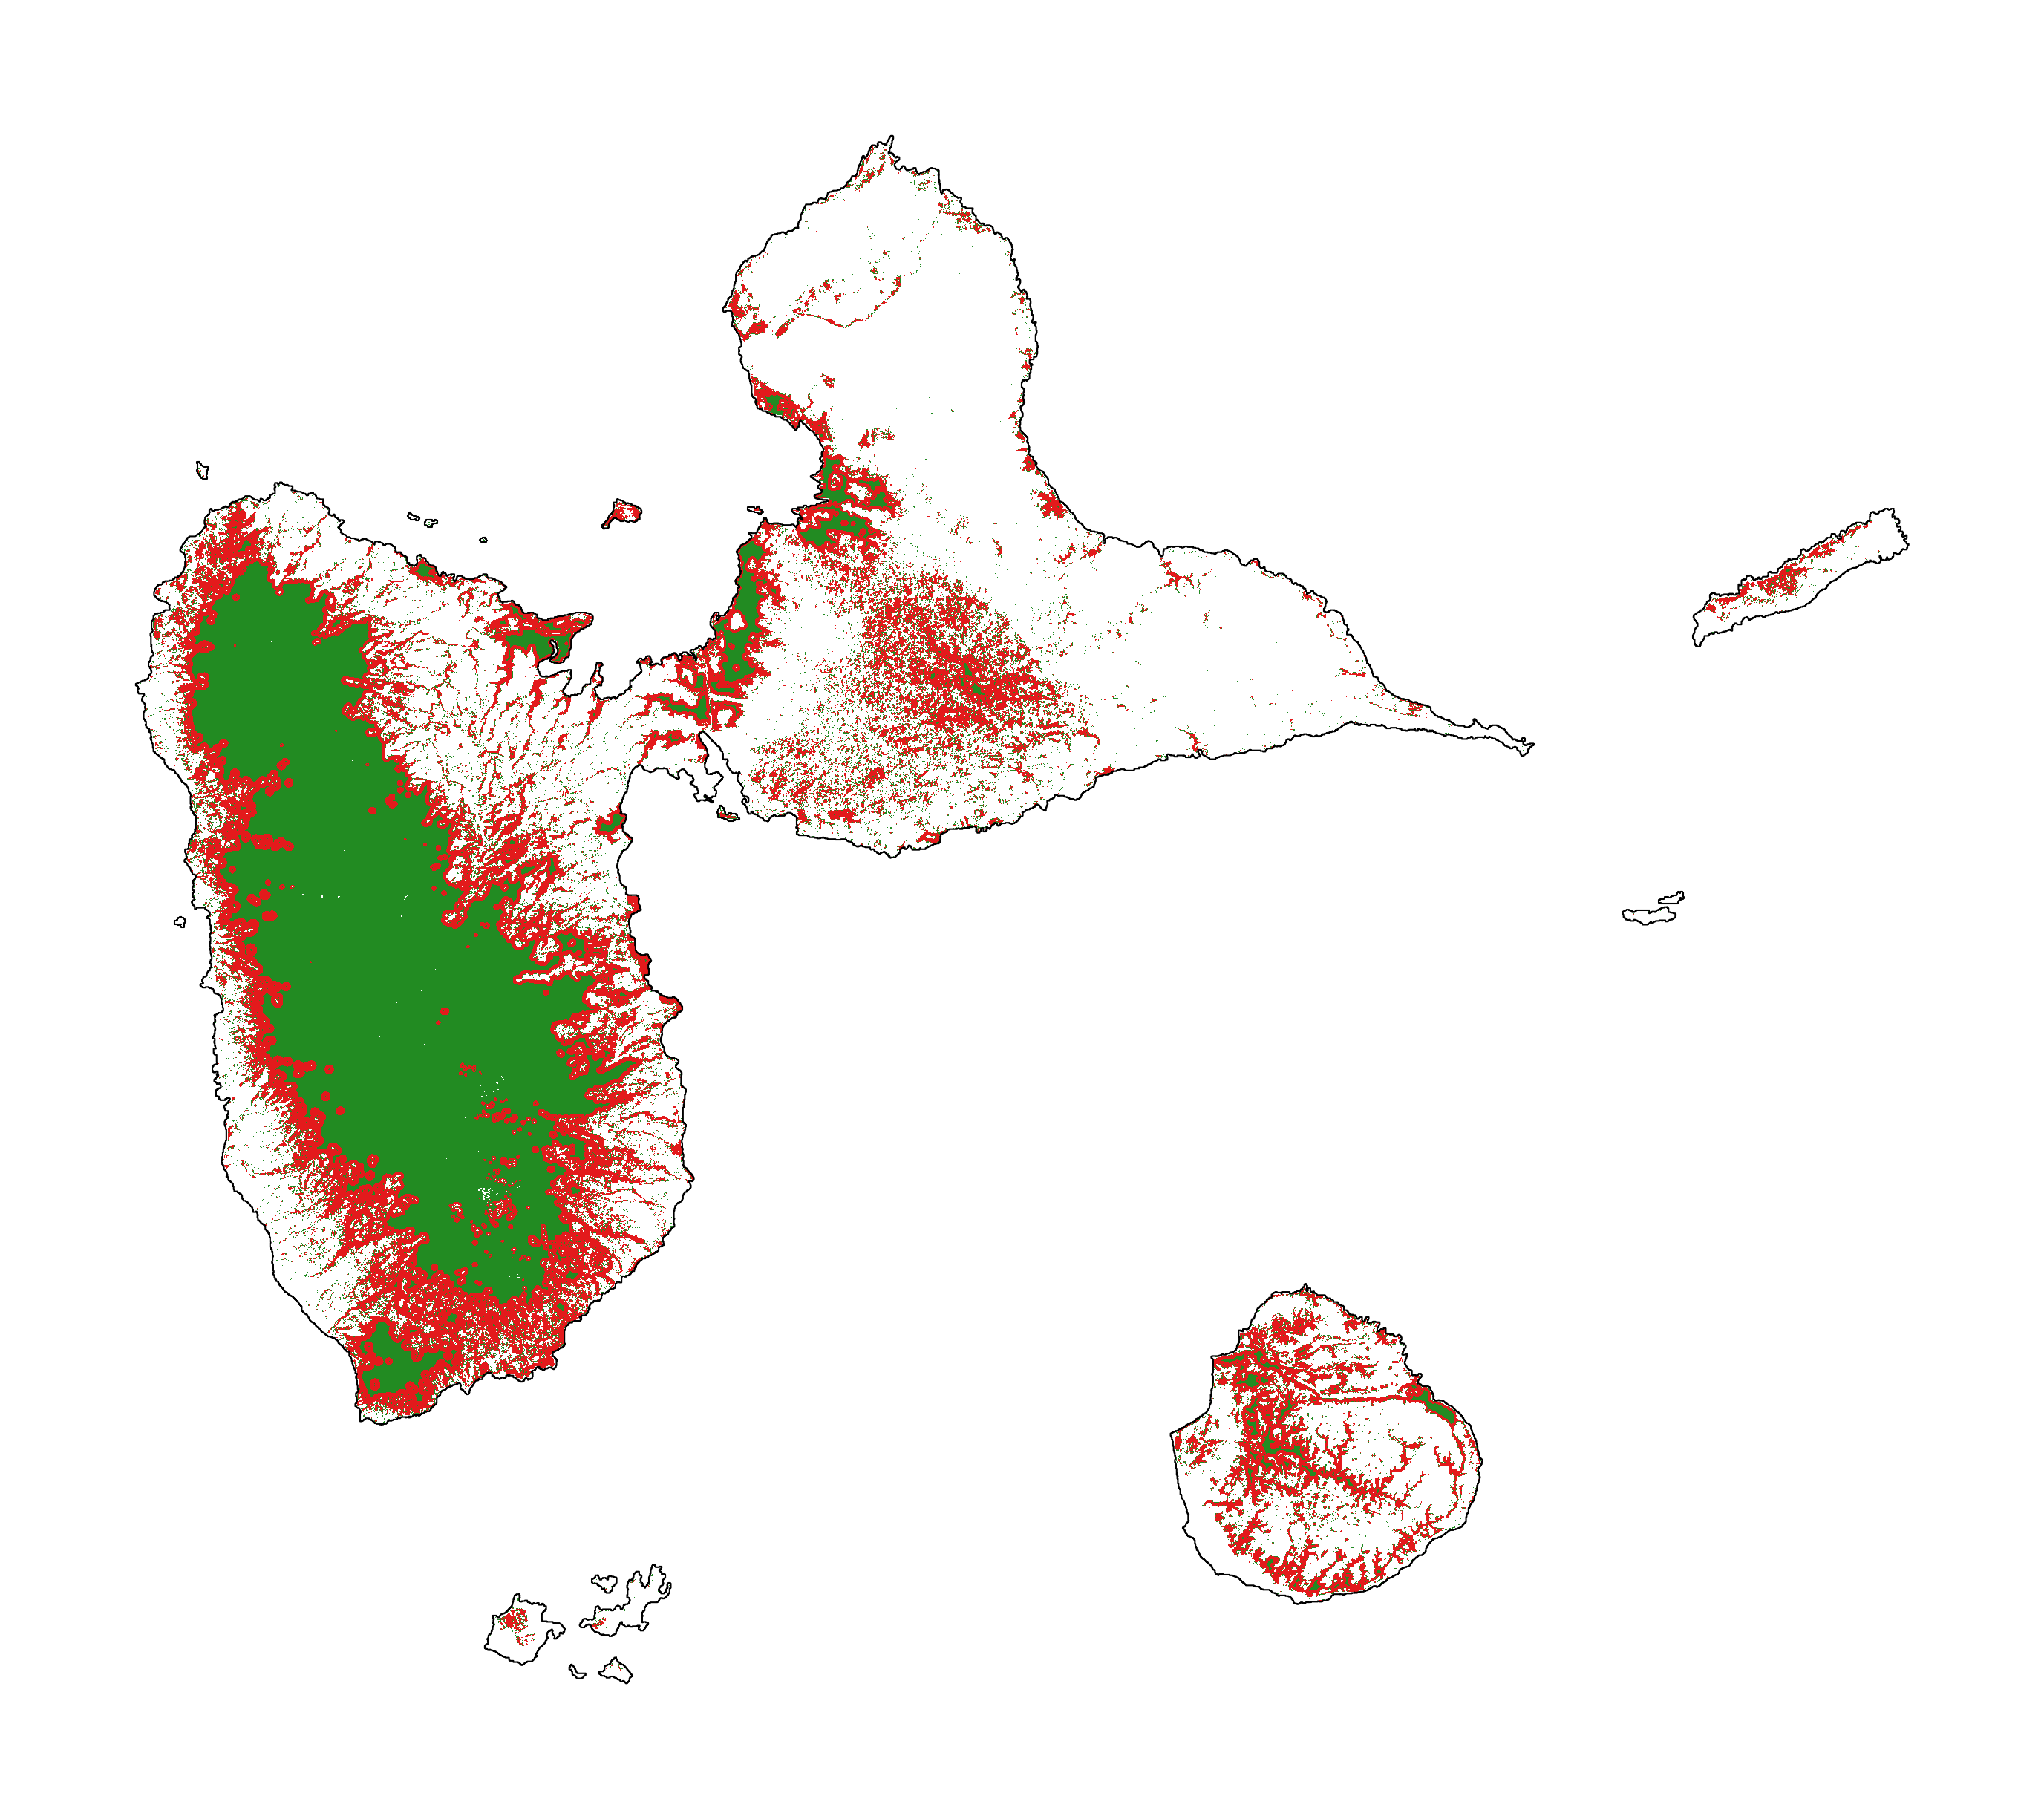

In [32]:
# Projected forest cover change (2020-2100)
fcc_2100 = far.plot.fcc("output/fcc_2100.tif",
                        maxpixels=1e8,
                        borders="data/ctry_PROJ.shp",
                        linewidth=0.3,
                        output_file="output/fcc_" + dates_fut[i] + ".png",
                        figsize=(6, 5), dpi=500)